In [1]:
# Importe les librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

# from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import cluster
from sklearn.cluster import DBSCAN

<img src='./images/logo-la-poule-qui-chante.png' width=480px />

# Produisez une étude de marché avec Python<br>Partie n°2 : *clustering*

> &#9888; Ce *notebook* est le second des deux *notebooks* qui vont composer notre étude de marché. Il contient l'analyse des groupements de pays en utilisant la classification ascendante hiérarchique puis la méthode des *k-means*. Il contient également une ACP afin de visualier les résultats de l'analyse.

Nous sommes en poste chez **La poule qui chante**, une entreprise française d’agroalimentaire qui souhaite se développer à l'international. Cependant, la liste des pays potentiels dans lesquels s'implanter est longue. Pour cela, nous allons réaliser une analyse des groupements de pays que l'on pourra cibler grâce à différentes méthodes de *clustering*, puis nous approfondirons l'étude de marché.

Le jeu de données qui va être utilisé a été préparé à partir des [statistiques de la *Food and Agriculture Organization of the United Nations (FAO)*](https://www.fao.org/faostat/fr/#home).
Il contient différents indicateurs, pour l'année 2017, sélectionnés ou calculés en nous inspirant de l'analyse PESTEL:
* l'indice de stabilité politique ;
* les importations en milliers de tonnes ;
* le revenu par habitant en $US
* la croissance moyenne du PIB entre 2010 et 2017 en % ;
* la population en milliers d'habitants ;
* la croissance moyenne de la population entre 2010 et 2017 en % ;
* la disponibilité de viande de volaille en kg/personne ;
* la production en milliers de tonnes ;
* la part de la population ayant accès à l'eau potable en % ;
* la part des terres à usage agricoles en % ;
* la densité de poulets dans l'élevage en UGB<sup>[1]</sup>/ha.

*1. Unité de gros bétail.*

## Sommaire

* [Importation du *dataset*](#1)
* [*Clusterings*](#2)
    * [Classification Ascendante Hiérarchique (CAH)](#2-1)

## Importation du *dataset*<a id='1'></a>

In [29]:
df_indicateurs = pd.read_csv('./datasets/indicateurs-zones-2017.csv')
df_indicateurs.head()

,zone,evolution_population_%,part_conso_volailles_%,importations_volailles_kt,tas_volailles_%,croissance_annuelle_%,revenu_par_habitant_usd,indice_stabilite_politique
0,Arménie,-0.22,1.488499,35.0,93.696200,9.305043,4184.835842,-0.62
1,Afghanistan,3.29,0.448368,29.0,81.869816,4.865790,537.126294,-2.80
2,Albanie,-0.45,0.979548,20.0,92.144814,9.765944,4532.791976,0.38
3,Algérie,1.72,0.923962,2.0,68.879152,6.287893,4081.775086,-0.92
4,Andorre,0.94,2.341613,16.0,93.748459,3.645145,40632.206414,1.42


Les calculs que nous allons effectuer par la suite nécessitent que nous n'ayons que des valeurs numériques dans notre *DataFrame*. Nous allons donc mettre la colonne « zone » en index et créer une liste des zones.

In [30]:
# Assigne la variable 'zone' à l'index
df_indicateurs = df_indicateurs.set_index('zone')

# Crée la liste des zones
zones = list(df_indicateurs.index)

df_indicateurs.head()

,evolution_population_%,part_conso_volailles_%,importations_volailles_kt,tas_volailles_%,croissance_annuelle_%,revenu_par_habitant_usd,indice_stabilite_politique
zone,,,,,,,
Arménie,-0.22,1.488499,35.0,93.696200,9.305043,4184.835842,-0.62
Afghanistan,3.29,0.448368,29.0,81.869816,4.865790,537.126294,-2.80
Albanie,-0.45,0.979548,20.0,92.144814,9.765944,4532.791976,0.38
Algérie,1.72,0.923962,2.0,68.879152,6.287893,4081.775086,-0.92
Andorre,0.94,2.341613,16.0,93.748459,3.645145,40632.206414,1.42


On peut ensuite afficher quelques informations générales.

In [31]:
print(f'Dimensions du DataFrame : {df_indicateurs.shape}\n')

df_indicateurs.info()

Dimensions du DataFrame : (211, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 211 entries, Arménie to Palestine
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   evolution_population_%      211 non-null    float64
 1   part_conso_volailles_%      211 non-null    float64
 2   importations_volailles_kt   211 non-null    float64
 3   tas_volailles_%             211 non-null    float64
 4   croissance_annuelle_%       211 non-null    float64
 5   revenu_par_habitant_usd     211 non-null    float64
 6   indice_stabilite_politique  211 non-null    float64
dtypes: float64(7)
memory usage: 13.2+ KB


Puis une description résumée de nos variables quantitatives.

In [32]:
df_indicateurs.describe().T.style.format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
evolution_population_%,211.00,1.41,1.35,-1.23,0.47,1.25,2.27,9.11
part_conso_volailles_%,211.00,2.90,2.31,0.09,1.39,2.34,3.60,12.46
importations_volailles_kt,211.00,74.42,168.96,0.00,5.00,16.00,57.50,1069.00
tas_volailles_%,211.00,95.45,29.37,12.61,87.63,93.75,100.87,266.05
croissance_annuelle_%,211.00,7.07,7.54,-27.93,4.39,7.26,9.94,36.13
revenu_par_habitant_usd,211.00,16442.46,24804.62,295.78,2015.64,6339.89,19806.13,178117.96
indice_stabilite_politique,211.00,-0.07,0.96,-2.94,-0.62,0.03,0.66,1.92


## *Clusterings*<a id='2'></a>

### Classification Ascendante Hiérarchique (CAH)<a id='2-1'></a>

On commence par convertir nos données en un *array* NumPy.

In [33]:
X = df_indicateurs.to_numpy()

Les variables ayant des échelles différentes, nous allons tout d'abord les centrer et les réduire.

In [34]:
# Instancie 'StandardScaler'
scaler = StandardScaler()

#  Calcule les moyennes et les écarts-types et standardise les données
X_scaled = scaler.fit_transform(X)

pd.DataFrame(X_scaled).head()

,0,1,2,3,4,5,6
0,-1.215734,-0.615529,-0.233878,-0.059777,0.297086,-0.495342,-0.582128
1,1.399004,-1.067729,-0.269474,-0.463394,-0.292938,-0.642749,-2.869760
2,-1.387070,-0.836796,-0.322869,-0.112723,0.358344,-0.481281,0.467244
3,0.229448,-0.860963,-0.429658,-0.906747,-0.103926,-0.499507,-0.896940
4,-0.351604,-0.244635,-0.346600,-0.057993,-0.455175,0.977531,1.558591


Puis on effectue le regroupement hiérarchique dont les résultats sont encodés dans la matrice de liaison. Cette dernière nous servira également à tracer le dendrogramme.

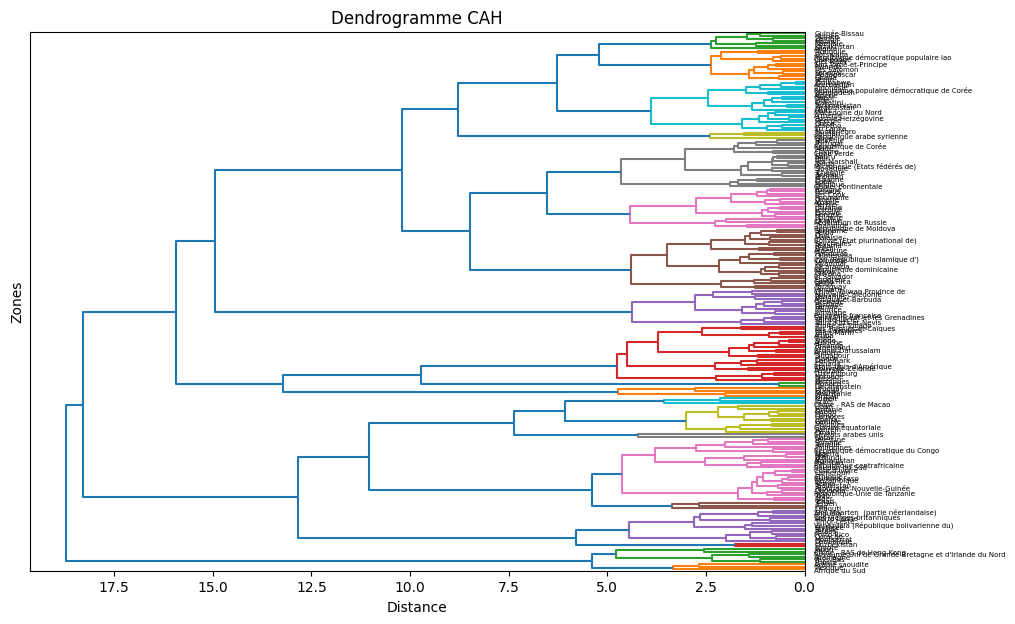

In [35]:
# Calcule la matrice de liaison
Z = linkage(X_scaled, method='ward', metric='euclidean')

# Initialise le graphique
fig, ax = plt.subplots(figsize=(10, 7))

# Trace le dendogramme
dn = dendrogram(Z, labels=zones, orientation='left', ax=ax, color_threshold=5)

ax.set_title('Dendrogramme CAH')
ax.set_xlabel('Distance')
ax.set_ylabel('Zones')

plt.show()

del fig, ax, dn

In [36]:
def plot_n_clusters_silhouette_score(y, max_n_clusters=30):
    """
    Trace le score de Silhouette moyen en fonction du nombre de clusters.
    Paramètres :
    - y : matrice de données à analyser
    - max_n_clusters : nombre maximum de clusters pour lequel effectuer le
    calcul.
    """
    silhouette_avg_scores = []

    # Calcul le score de Silhouette moyen chaque nombre de clusters et
    # l'ajoute à la liste.
    for n_clusters in range(2, (max_n_clusters+1)):
        clustering = AgglomerativeClustering(n_clusters=n_clusters,
                                             linkage='ward')
        clustering = clustering.fit(y)
        cluster_labels = clustering.labels_
        silhouette_avg = silhouette_score(y, cluster_labels)
        silhouette_avg_scores.append(silhouette_avg)

    # Initialise le graphique
    fig, ax = plt.subplots(figsize=(8, 5))

    # Trace le graphique
    plt.plot(range(2, (max_n_clusters+1)), silhouette_avg_scores, marker='o',
             markeredgecolor='w')

    # Définie la position des graduations et affiche le quadrillage
    ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))
    ax.grid(axis='both', which='major', visible=True, linestyle=':')

    ax.set_xlabel('n_clusters')
    ax.set_ylabel('silhouette_avg')
    ax.set_title(f'Coefficient de Silhouette en fonction\n'
                 f'du nombre de clusters')

    plt.show()

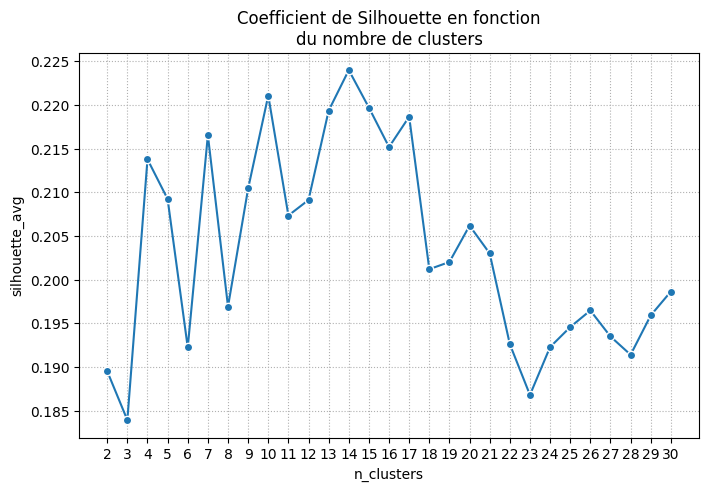

In [13]:
plot_n_clusters_silhouette_score(X_scaled)

In [41]:
num_clusters = 10

clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
clustering = clustering.fit(X)

df_resultats = df_indicateurs.copy()

df_resultats['cluster_cah'] = clustering.labels_

cluster_stats_cah = df_resultats.groupby('cluster_cah').mean(numeric_only=True)

cluster_stats_cah.style.background_gradient(axis=0)

,evolution_population_%,part_conso_volailles_%,importations_volailles_kt,tas_volailles_%,croissance_annuelle_%,revenu_par_habitant_usd,indice_stabilite_politique
cluster_cah,,,,,,,
0,0.611765,4.185087,59.441176,94.125305,6.409065,17683.424206,0.476471
1,1.112353,3.258364,344.764706,86.763313,4.859449,43807.571517,0.735882
2,1.525000,3.851822,67.500000,79.564341,4.035147,30429.349391,0.320000
3,1.396000,2.787765,17.800000,100.662835,9.164885,76173.920544,1.308000
4,1.205179,2.836442,45.375000,99.582910,8.989755,4334.419495,-0.176607
5,0.885000,2.341613,16.000000,93.748459,1.612579,175864.889236,0.030000
6,-0.200000,2.341613,16.000000,93.748459,3.513146,114601.928092,1.000000
7,2.280000,3.213422,62.875000,105.086125,6.847328,56822.679982,0.793750
8,1.042917,4.395576,112.500000,95.232241,8.235000,8982.046179,-0.027917


In [42]:
for i in range(num_clusters):
    print(f'Cluster {i} - {len(df_resultats[df_resultats["cluster_cah"] == i].index.tolist())} individus')
    print(df_resultats[df_resultats['cluster_cah'] == i].index.tolist())

Cluster 0 - 34 individus
['Antigua-et-Barbuda', 'Argentine', 'Bahreïn', 'Barbade', 'Chili', 'Îles Cook', 'Chypre', 'Estonie', 'Polynésie française', 'Grèce', 'Hongrie', 'Croatie', 'Lettonie', 'Lituanie', 'Malte', 'Montserrat', 'Nauru', 'Panama', 'Tchéquie', 'Pologne', 'Portugal', 'Porto Rico', 'Palaos', 'Saint-Kitts-et-Nevis', 'Arabie saoudite', 'Seychelles', 'Slovénie', 'Slovaquie', 'Chine, Taiwan Province de', 'Trinité-et-Tobago', 'Oman', 'Uruguay', 'Anguilla', 'Curaçao']
Cluster 1 - 17 individus
['Andorre', 'Autriche', 'Canada', 'Finlande', 'France', 'Allemagne', 'Groenland', 'Chine - RAS de Hong-Kong', 'Israël', 'Japon', 'Pays-Bas', 'Nouvelle-Zélande', 'Saint-Marin', 'Émirats arabes unis', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Îles Vierges britanniques', 'Belgique']
Cluster 2 - 10 individus
['Bahamas', 'Aruba', 'Brunéi Darussalam', 'Italie', 'République de Corée', 'Koweït', 'Nouvelle-Calédonie', 'Espagne', 'Îles Turques-et-Caïques', 'Sint Maarten  (partie néerland

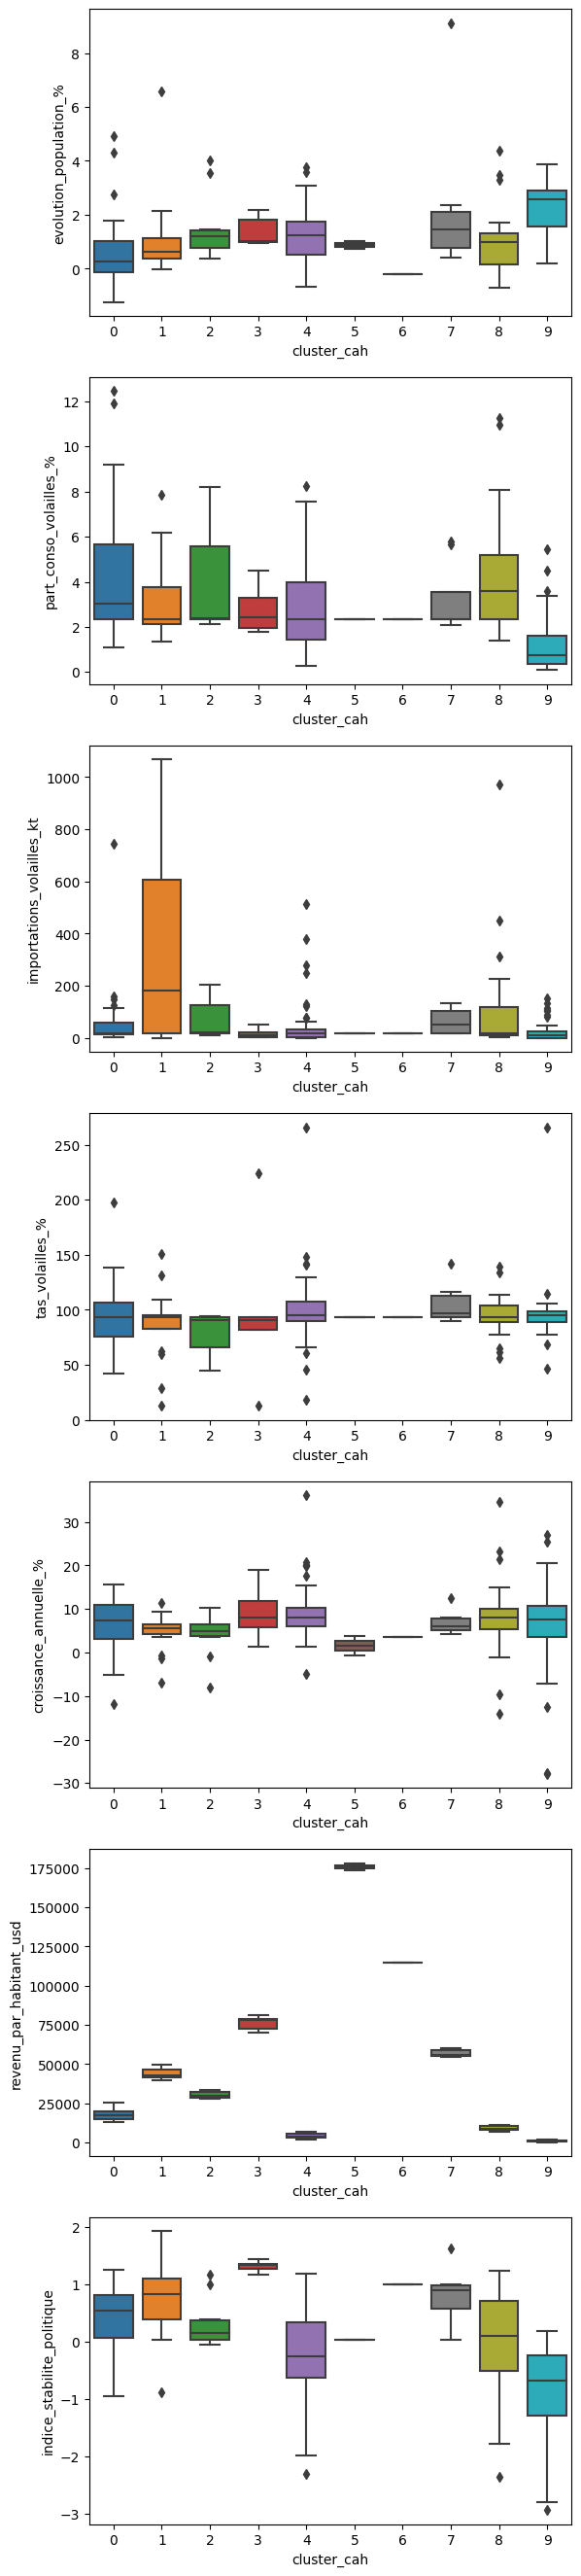

In [43]:
fig, axs = plt.subplots(len(df_indicateurs.columns), 1, figsize=(6.4, 4.8*len(df_indicateurs.columns)))

for i, indicateur in enumerate(df_indicateurs.columns):
    sns.boxplot(y=df_resultats[indicateur], x=df_resultats['cluster_cah'], ax=axs[i])

### K-Means<a id='2-2'></a>

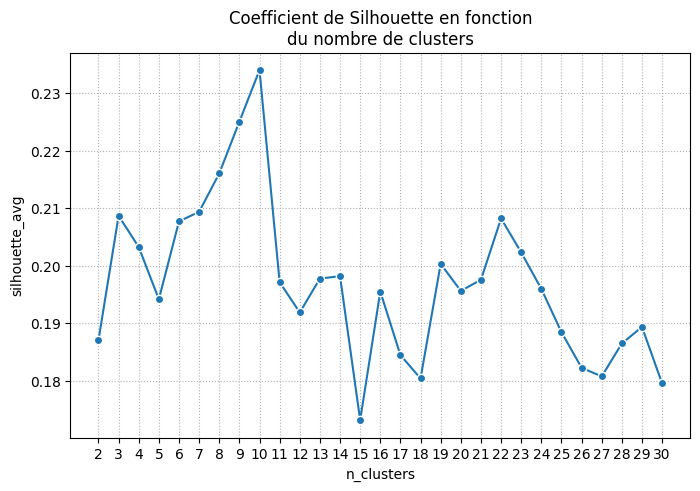

In [45]:
# Calcul le coefficient de silhouette en fonction du nombre de clusters
silhouettes = []
for num_clusters in range(2, 31):
    cls=cluster.KMeans(n_clusters=num_clusters,
                        n_init='auto', init='random', random_state=0)
    cls.fit(X_scaled)
    silh = silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)

fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(range(2, 31), silhouettes, marker='o', markeredgecolor='w')

ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))
ax.grid(axis='both', which='major', visible=True, linestyle=':')

ax.set_xlabel('n_clusters')
ax.set_ylabel('silhouette_avg')
ax.set_title(f'Coefficient de Silhouette en fonction\n'
             f'du nombre de clusters')

plt.show()

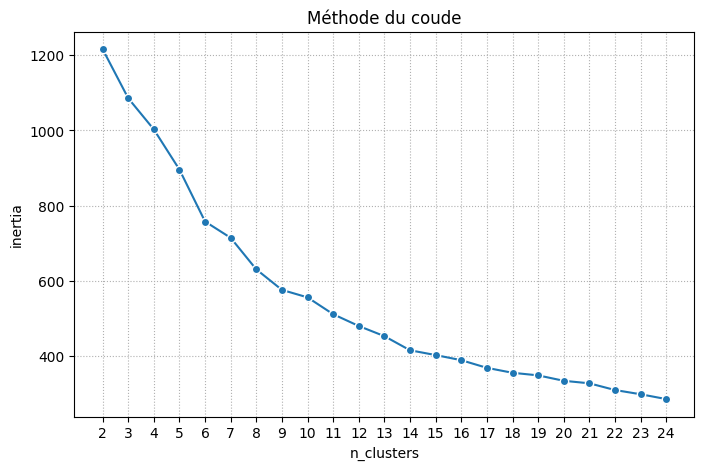

In [46]:
# Méthode du coude
inertias=[]
for num_clusters in range(2, 25):
    cls=cluster.KMeans(n_clusters=num_clusters,
                        n_init='auto', init='k-means++', random_state=0)
    cls.fit(X_scaled)
    inertias.append(cls.inertia_)

fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(range(2, 25), inertias, marker='o', markeredgecolor='w')

ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))
ax.grid(axis='both', which='major', visible=True, linestyle=':')

ax.set_xlabel('n_clusters')
ax.set_ylabel('inertia')
ax.set_title('Méthode du coude')

plt.show()

In [49]:
num_clusters = 10

clustering = cluster.KMeans(n_clusters=num_clusters,
                        n_init='auto', init='k-means++', random_state=0)
clustering.fit(X_scaled)

df_resultats = df_indicateurs.copy()

df_resultats['cluster_kmeans'] = clustering.labels_

cluster_stats_kmeans = df_resultats.groupby('cluster_kmeans').mean(numeric_only=True)

cluster_stats_kmeans.style.background_gradient(axis=0)

,evolution_population_%,part_conso_volailles_%,importations_volailles_kt,tas_volailles_%,croissance_annuelle_%,revenu_par_habitant_usd,indice_stabilite_politique
cluster_kmeans,,,,,,,
0,0.336000,2.464401,87.400000,98.194132,28.217853,5496.012136,-1.894000
1,4.067333,3.614162,75.066667,80.591735,5.838513,16089.245701,-0.020000
2,1.037500,2.870404,48.150000,98.174393,6.015674,72016.641889,1.005500
3,0.974583,7.664449,26.875000,84.903647,6.188221,14274.270433,0.331250
4,1.180000,5.374851,923.000000,51.667161,4.782579,29433.547997,0.125000
5,0.455672,2.534266,38.477612,99.482788,7.938352,11234.168730,0.333881
6,1.477500,2.225761,7.500000,238.494389,10.712346,23698.943672,0.662500
7,1.970714,1.748668,33.142857,87.713991,-9.717356,8450.412506,-0.970714
8,2.313725,1.181178,34.411765,92.556546,9.532887,1942.858646,-0.908824


In [50]:
for i in range(num_clusters):
    print(f'Cluster {i} - {len(df_resultats[df_resultats["cluster_kmeans"] == i].index.tolist())} individus')
    print(df_resultats[df_resultats['cluster_kmeans'] == i].index.tolist())

Cluster 0 - 5 individus
['Libye', 'Fédération de Russie', 'République arabe syrienne', 'Ukraine', 'Soudan']
Cluster 1 - 15 individus
['Bahreïn', 'Belize', 'Comores', 'Congo', 'Guinée équatoriale', 'Gabon', 'Gambie', 'Jordanie', 'Koweït', 'Libéria', 'Maldives', 'Qatar', 'Oman', 'Îles Turques-et-Caïques', 'Émirats arabes unis']
Cluster 2 - 20 individus
['Andorre', 'Australie', 'Autriche', 'Bermudes', 'Canada', 'Îles Caïmanes', 'Danemark', 'Finlande', 'Groenland', 'Irlande', 'Liechtenstein', 'Chine - RAS de Macao', 'Monaco', 'Nouvelle-Zélande', 'Norvège', 'Singapour', 'Suède', 'Suisse', "États-Unis d'Amérique", 'Luxembourg']
Cluster 3 - 24 individus
['Antigua-et-Barbuda', 'Bahamas', 'Barbade', 'Bolivie (État plurinational de)', 'Brésil', 'Myanmar', 'Chili', 'Polynésie française', 'Grenade', 'Israël', 'Jamaïque', 'Malaisie', 'Maurice', 'Nouvelle-Calédonie', 'Panama', 'Pérou', 'Saint-Kitts-et-Nevis', 'Sainte-Lucie', 'Saint-Vincent-et-les Grenadines', 'Seychelles', 'Suriname', 'Chine, Taiwan

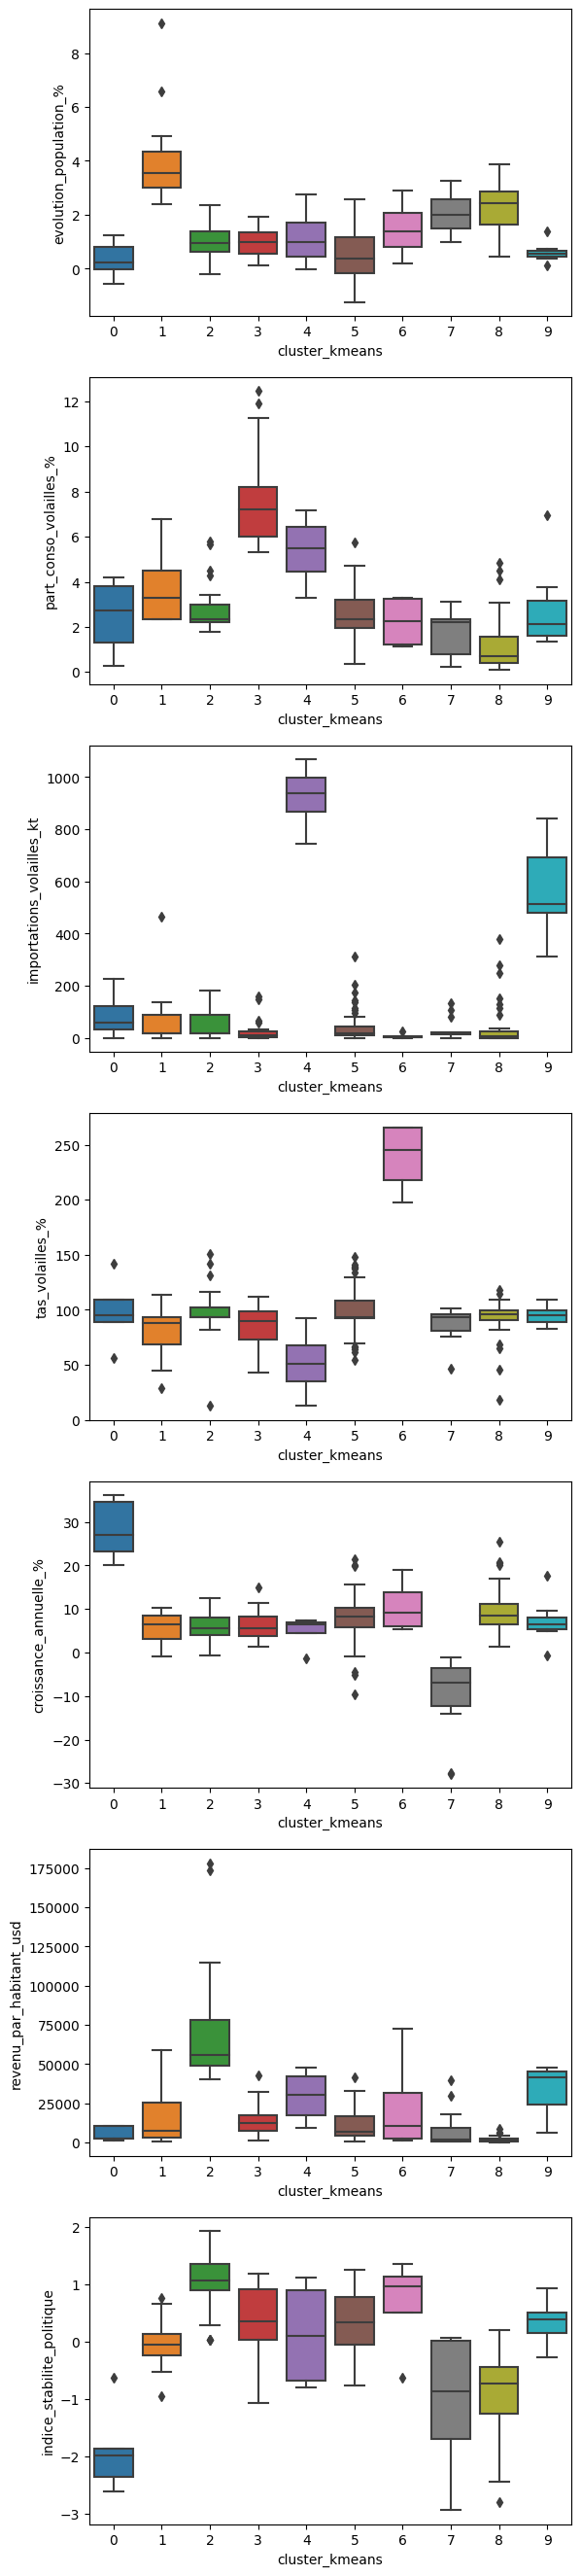

In [51]:
fig, axs = plt.subplots(len(df_indicateurs.columns), 1, figsize=(6.4, 4.8*len(df_indicateurs.columns)))

for i, indicateur in enumerate(df_indicateurs.columns):
    sns.boxplot(y=df_resultats[indicateur], x=df_resultats['cluster_kmeans'], ax=axs[i])

### DBSCAN<a id='2-4'></a>

In [109]:
clustering = DBSCAN(eps=1, min_samples=2)
clustering.fit(X_scaled)

n_clusters_ = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
n_noise_ = list(clustering.labels_).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

clustering.labels_

Estimated number of clusters: 10
Estimated number of noise points: 73


array([ 0, -1,  0,  0,  1, -1, -1, -1, -1,  1, -1, -1,  0,  0, -1,  0,  0,
       -1,  0,  0,  0,  0,  1,  0, -1,  0,  0, -1,  0, -1, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0,  0,  0, -1,  0,
        0,  0,  0,  1, -1,  0, -1,  0,  0,  2, -1,  0,  0, -1,  0,  1,  0,
        0, -1,  0, -1,  0, -1,  0,  0, -1,  0,  0,  0, -1, -1, -1,  0,  0,
       -1,  0, -1, -1,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  2, -1,  3,
        0,  0, -1,  0,  4,  0,  0,  0, -1, -1,  0, -1,  3, -1,  0,  0,  0,
        0, -1, -1,  0,  0, -1, -1,  0, -1, -1,  0,  0,  5,  6,  0,  0,  0,
        0, -1,  0, -1,  0,  0,  0,  7,  0, -1, -1,  0,  0,  0,  0, -1,  8,
        8,  8,  0,  0, -1,  0,  0,  7,  0,  0, -1,  0, -1,  0,  0,  0,  0,
        1,  6, -1,  0, -1,  0, -1,  0,  0, -1, -1, -1, -1, -1, -1,  0,  0,
       -1, -1, -1,  0, -1, -1, -1,  0,  0,  9,  0, -1,  5,  4, -1,  6,  9,
        0,  0, -1, -1,  0,  9,  0], dtype=int64)

### ACP<a id='2-4'></a>

In [56]:
pca = decomposition.PCA(n_components=7)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_.cumsum())

[0.25534445 0.44530533 0.59132834 0.7207344  0.83464332 0.93186444
 1.        ]


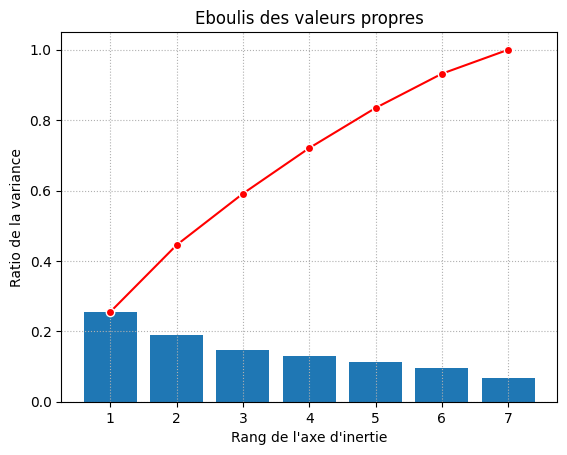

In [57]:
fig, ax = plt.subplots()

plt.bar(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_)
plt.plot(np.arange(len(pca.explained_variance_ratio_.cumsum()))+1, pca.explained_variance_ratio_.cumsum(), c='r',marker='o',  markeredgecolor='w')

ax.grid(axis='both', which='major', visible=True, linestyle=':')

ax.set_xlabel('Rang de l\'axe d\'inertie')
ax.set_ylabel('Ratio de la variance')
ax.set_title('Eboulis des valeurs propres')

plt.show()

In [58]:
pca = decomposition.PCA(n_components=7)
pca.fit(X_scaled)

X_projected = pca.transform(X_scaled)

In [59]:
df_indicateurs.columns

Index(['evolution_population_%', 'part_conso_volailles_%',
       'importations_volailles_kt', 'tas_volailles_%', 'croissance_annuelle_%',
       'revenu_par_habitant_usd', 'indice_stabilite_politique'],
      dtype='object')

In [60]:
# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
# coeff = np.transpose(pca.components_)
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

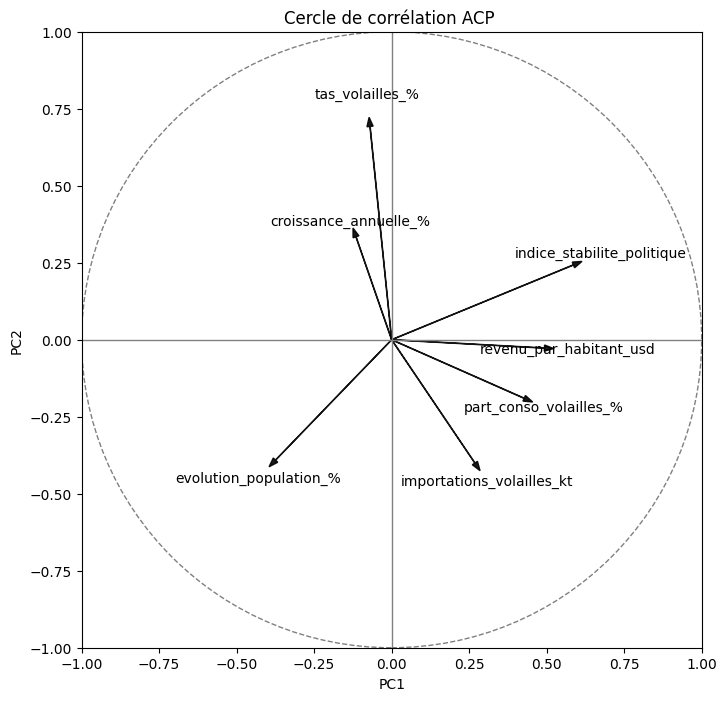

In [61]:
# Créer la figure
plt.figure(figsize=(8, 8))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, df_indicateurs.columns[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cercle de corrélation ACP ')

# Afficher la figure
plt.show()

In [62]:
# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[2:5, :])
# coeff = np.transpose(pca.components_)
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

In [28]:
coeff

array([[ 0.18605285, -0.26009336,  0.27837048],
       [-0.23026036,  0.00438176, -0.4003156 ],
       [ 0.37556335,  0.855421  , -0.15726184],
       [ 0.79508628, -0.24390061, -0.27692765],
       [ 0.28808713, -0.01851768,  0.60105219],
       [-0.07822661, -0.00986714, -0.02097826],
       [ 0.14922223, -0.08337068,  0.26776262],
       [-0.16665417,  0.36566203,  0.47690297]])

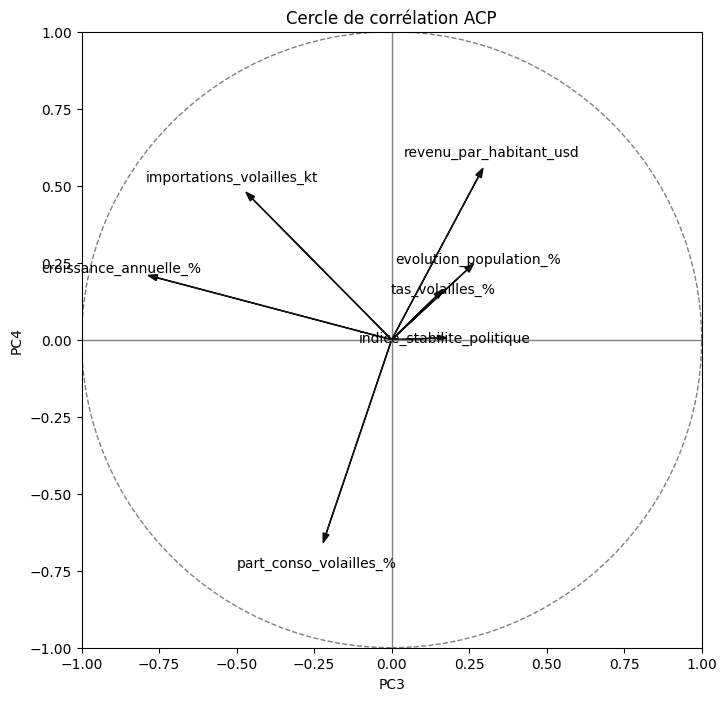

In [63]:
# Créer la figure
plt.figure(figsize=(8, 8))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, df_indicateurs.columns[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC3')
plt.ylabel('PC4')
plt.title('Cercle de corrélation ACP')

# Afficher la figure
plt.show()

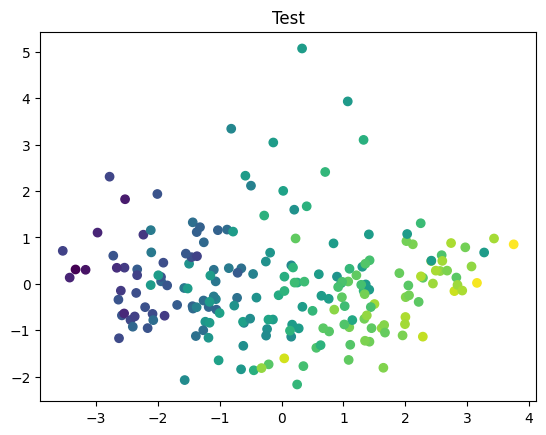

In [34]:
fig = plt.figure()
ax = fig.add_subplot()

# afficher chaque observation
ax.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable 'Rank'
    c=df_resultats['dispo_proteiques_animale_%'])
ax.set_title('Test')
# ax.set_xlim([-4, 4])
# ax.set_ylim([-4, 4])

plt.show()

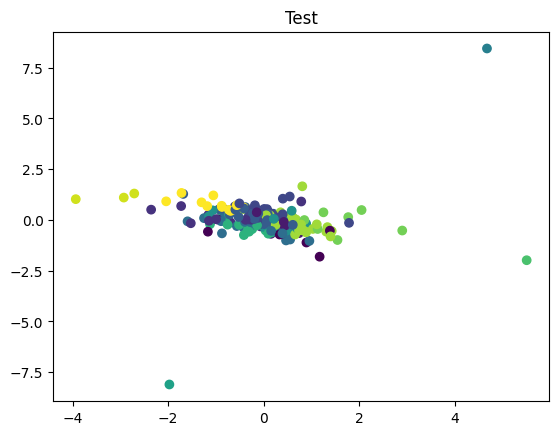

In [31]:
fig = plt.figure()
ax = fig.add_subplot()

# afficher chaque observation
ax.scatter(X_projected[:, 2], X_projected[:, 3],
    # colorer en utilisant la variable 'Rank'
    c=df_resultats['cluster_kmeans'])
ax.set_title('Test')
# ax.set_xlim([-4, 4])
# ax.set_ylim([-4, 4])

plt.show()

NameError: name 'X_norm' is not defined

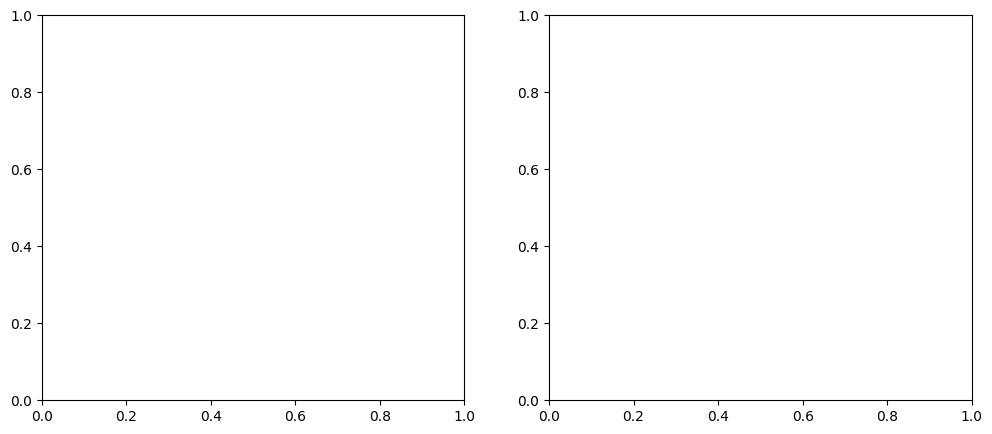

In [32]:
# Affiche les données pour 2 et 3 clusters
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cls2 = cluster.KMeans(n_clusters=2, n_init=1)
cls2.fit(X_norm)
ax[0].scatter(X_trans[:, 0], X_trans[:, 1], c=cls2.labels_)

cls3 = cluster.KMeans(n_clusters=10, n_init=1)
cls3.fit(X_norm)
ax[1].scatter(X_trans[:, 0], X_trans[:, 1], c=cls3.labels_)

## TEMP

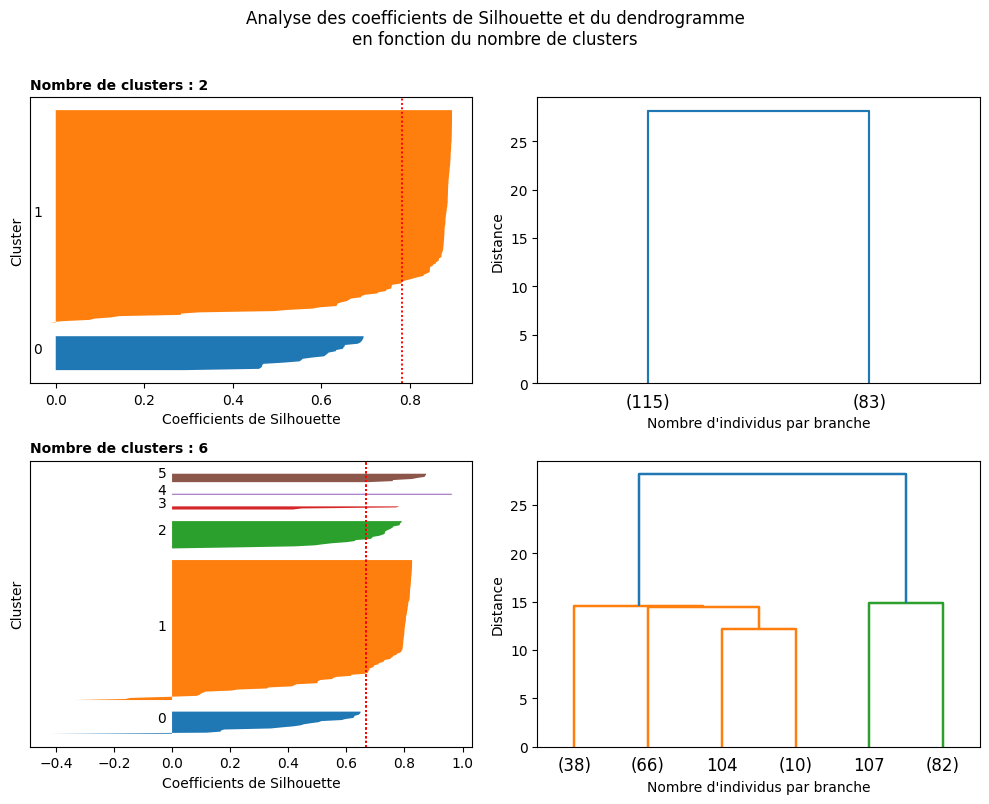

In [ ]:
def plot_cah_silhouette_analysis(y, n_clusters_list, method='ward', metric='euclidean'):

    Z = linkage(y, method=method, metric=metric)

    fig, axs = plt.subplots(
        nrows=len(n_clusters_list), ncols=2, figsize=(10, (len(n_clusters_list)*4))
    )

    r = 0

    for n_clusters in n_clusters_list:
        clustering = (
            AgglomerativeClustering(n_clusters=n_clusters, linkage=method, metric=metric)
        ).fit(X)
        
        sample_silhouette_values = silhouette_samples(X, clustering.labels_)

        silhouette_avg = silhouette_score(X, clustering.labels_)

        y_lower = 10
        
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[clustering.labels_ == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]

            y_upper = y_lower + size_cluster_i
            
            axs[r, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
            axs[r, 0].text(-0.05, (y_lower+0.5*size_cluster_i), str(i))
            axs[r, 0].set_yticks([])
            axs[r, 0].axvline(x=silhouette_avg, color="red", linestyle=":", linewidth=1.2)
            axs[r, 0].set_xlabel('Coefficients de Silhouette')
            axs[r, 0].set_ylabel('Cluster')
            axs[r, 0].set_title(f'Nombre de clusters : {n_clusters}', size=10, fontweight='bold', loc='left')

            y_lower = y_upper + 10

            dn = dendrogram(Z, ax=axs[r, 1], p=n_clusters, truncate_mode='lastp')
            axs[r, 1].set_xlabel('Nombre d\'individus par branche')
            axs[r, 1].set_ylabel('Distance')

        r += 1

    fig.suptitle(f'Analyse des coefficients de Silhouette et du dendrogramme\n'
                f'en fonction du nombre de clusters',
                y=1)

    plt.tight_layout()

    plt.show()

plot_cah_silhouette_analysis(X_scaled, [2,6])